# Imports

In [1]:
%%time

import numpy
import geopandas
import folium
import pandas
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import clear_output
import os

%matplotlib inline
%pylab inline

seaborn.set_style('whitegrid')

print('numpy: ' + numpy.__version__)
print('geopandas: ' + geopandas.__version__)
print('folium: ' + folium.__version__)
print('pandas: ' + pandas.__version__)
print('seaborn: ' + seaborn.__version__)
print('matplotlib: ' + matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
numpy: 1.13.3
geopandas: 0.3.0
folium: 0.5.0
pandas: 0.20.3
seaborn: 0.8.1
matplotlib: 2.1.0
CPU times: user 3.14 s, sys: 233 ms, total: 3.38 s
Wall time: 3.57 s


# Homicide reports 1980-2014
## Reading & filtering data
### First attempt to read data

In [2]:
homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz")
# homicide.columns returns the column name on index 16
homicide[homicide.columns[16]].head(5)

/home/duncan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0    15
1    42
2     0
3    42
4     0
Name: Perpetrator Age, dtype: object

### Perpetrator age contains int try and convert to int

In [3]:
# Abuse python type converter to find what our dirty data is
try:
    #homicide['Perpetrator Age'].apply(pandas.to_numeric)
    homicide['Perpetrator Age'].astype(int)
except ValueError as e:
    print(str(type(e).__name__) + ": " + str(e.args))

ValueError: ("invalid literal for int() with base 10: ' '",)


### Check dirty data field

In [4]:
# Check what data our dirty row contains
homicide[homicide['Perpetrator Age'] == ' ']

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
634666,634667,OK07205,Tulsa,Municipal Police,Tulsa,Oklahoma,2014,June,104,Murder or Manslaughter,...,Not Hispanic,Unknown,,Unknown,Unknown,Unknown,Handgun,0,0,FBI


In [5]:
# Select column with dirty data so we can see all column fields
homicide.iloc[634666]

Record ID                                634667
Agency Code                             OK07205
Agency Name                               Tulsa
Agency Type                    Municipal Police
City                                      Tulsa
State                                  Oklahoma
Year                                       2014
Month                                      June
Incident                                    104
Crime Type               Murder or Manslaughter
Crime Solved                                 No
Victim Sex                                 Male
Victim Age                                   46
Victim Race                               Black
Victim Ethnicity                   Not Hispanic
Perpetrator Sex                         Unknown
Perpetrator Age                                
Perpetrator Race                        Unknown
Perpetrator Ethnicity                   Unknown
Relationship                            Unknown
Weapon                                  

In [6]:
# Make sure Crime Solved doesn't contain anything else then Yes or No.
homicide[(homicide['Crime Solved'] != 'No') & (homicide['Crime Solved'] != 'Yes')]

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source


### Filter and generalize data and save to a csv for future use

In [7]:
%%time

homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz", dtype={"Perpetrator Age": object}) \
                            .drop(['Record ID', 'Agency Code'], axis=1)

# loc[row index, column index] when assiging a value the column index is important.
homicide.loc[homicide['Crime Solved'] == 'No', 'Crime Solved'] = False
# We don't set Yes to true because all strings are converted to True anyway
homicide['Crime Solved'] = homicide['Crime Solved'].astype(bool)

# Perpetrator Age contains dirty data
# homicide['Perpetrator Age'] = homicide['Perpetrator Age'].replace(' ', 0).apply(pandas.to_numeric)

homicide.loc[homicide['Perpetrator Age'] == ' ', 'Perpetrator Age'] = 0
# set dtype to int
homicide['Perpetrator Age'] = homicide['Perpetrator Age'].astype(int)

# Generalize relationships
homicide['General relation'] = homicide['Relationship']
homicide.loc[(homicide['Relationship'] == 'Wife') | (homicide['Relationship'] == 'Ex-Wife') |
             (homicide['Relationship'] == 'Girlfriend') |
             (homicide['Relationship'] == 'Common-Law Wife'), 'General relation'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Husband') | (homicide['Relationship'] == 'Ex-Husband') |
             (homicide['Relationship'] == 'Boyfriend') |
             (homicide['Relationship'] == 'Common-Law Husband'), 'General relation'] = 'Partner-M'

homicide.loc[(homicide['Relationship'] == 'Father') | (homicide['Relationship'] == 'In-Law') |
             (homicide['Relationship'] == 'Mother') | (homicide['Relationship'] == 'Stepfather') |
             (homicide['Relationship'] == 'Stepmother'), 'General relation'] = 'Parent'

homicide.loc[(homicide['Relationship'] == 'Daughter') | (homicide['Relationship'] == 'Son') |
             (homicide['Relationship'] == 'Stepdaughter') |
             (homicide['Relationship'] == 'Stepson'), 'General relation'] = 'Children'

homicide.loc[(homicide['Relationship'] == 'Brother') | (homicide['Relationship'] == 'Sister'),
             'General relation'] = 'Sibling'

homicide.loc[(homicide['Relationship'] == 'Employee') | (homicide['Relationship'] == 'Employer'),
             'General relation'] = 'Work'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & (homicide['Victim Sex'] == 'Female'),
             'General relation'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & ((homicide['Victim Sex'] == 'Male') |
            (homicide['Victim Sex'] == 'Unknown')), 'General relation'] = 'Partner-M'

homicide.to_csv('./datasets/homocide_reports_1980-2014_filtered.csv.gz', index = False, compression = 'gzip')

homicide

CPU times: user 44.5 s, sys: 1.26 s, total: 45.8 s
Wall time: 47.3 s


### Load pre-filtered csv

In [8]:
%time homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014_filtered.csv.gz")

CPU times: user 6.35 s, sys: 592 ms, total: 6.94 s
Wall time: 7.56 s


In [9]:
homicide

,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,...,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,General relation
0,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,True,Male,...,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,Acquaintance
1,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,True,Male,...,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,Acquaintance
2,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,False,Female,...,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI,Unknown
3,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,True,Male,...,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,Acquaintance
4,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,False,Female,...,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI,Unknown
5,Anchorage,Municipal Police,Anchorage,Alaska,1980,May,1,Murder or Manslaughter,True,Male,...,Male,36,White,Unknown,Acquaintance,Rifle,0,0,FBI,Acquaintance
6,Anchorage,Municipal Police,Anchorage,Alaska,1980,May,2,Murder or Manslaughter,True,Female,...,Male,27,Black,Unknown,Wife,Knife,0,0,FBI,Partner-F
7,Anchorage,Municipal Police,Anchorage,Alaska,1980,June,1,Murder or Manslaughter,True,Female,...,Male,35,White,Unknown,Wife,Knife,0,0,FBI,Partner-F
8,Anchorage,Municipal Police,Anchorage,Alaska,1980,June,2,Murder or Manslaughter,False,Male,...,Unknown,0,Unknown,Unknown,Unknown,Firearm,0,0,FBI,Unknown
9,Anchorage,Municipal Police,Anchorage,Alaska,1980,June,3,Murder or Manslaughter,True,Male,...,Male,40,Unknown,Unknown,Unknown,Firearm,0,1,FBI,Unknown


### Check if we have null fields in our columns

In [10]:
%time homicide.isnull().any()

CPU times: user 1.69 s, sys: 4.01 ms, total: 1.69 s
Wall time: 1.73 s


Agency Name              False
Agency Type              False
City                     False
State                    False
Year                     False
Month                    False
Incident                 False
Crime Type               False
Crime Solved             False
Victim Sex               False
Victim Age               False
Victim Race              False
Victim Ethnicity         False
Perpetrator Sex          False
Perpetrator Age          False
Perpetrator Race         False
Perpetrator Ethnicity    False
Relationship             False
Weapon                   False
Victim Count             False
Perpetrator Count        False
Record Source            False
General relation         False
dtype: bool

### Check types per comumn

In [11]:
%time homicide.dtypes

CPU times: user 682 µs, sys: 33 µs, total: 715 µs
Wall time: 730 µs


Agency Name              object
Agency Type              object
City                     object
State                    object
Year                      int64
Month                    object
Incident                  int64
Crime Type               object
Crime Solved               bool
Victim Sex               object
Victim Age                int64
Victim Race              object
Victim Ethnicity         object
Perpetrator Sex          object
Perpetrator Age           int64
Perpetrator Race         object
Perpetrator Ethnicity    object
Relationship             object
Weapon                   object
Victim Count              int64
Perpetrator Count         int64
Record Source            object
General relation         object
dtype: object

### Print description of our data set

In [12]:
%time homicide.describe()

CPU times: user 499 ms, sys: 0 ns, total: 499 ms
Wall time: 533 ms


,Year,Incident,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count
count,638454.000000,638454.000000,638454.000000,638454.000000,638454.000000,638454.000000
mean,1995.801102,22.967924,35.033512,20.322665,0.123334,0.185224
std,9.927693,92.149821,41.628306,17.886846,0.537733,0.585496
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1987.000000,1.000000,22.000000,0.000000,0.000000,0.000000
50%,1995.000000,2.000000,30.000000,21.000000,0.000000,0.000000
75%,2004.000000,10.000000,42.000000,31.000000,0.000000,0.000000
max,2014.000000,999.000000,998.000000,99.000000,10.000000,10.000000


## Show victim sex

In [13]:
inputGender = widgets.Text(description="Perpetrator Sex:")
display(inputGender)

def submit(sender):
    clear_output()
    display(inputGender)
    gender = inputGender.value
    homicidefiltered = homicide[homicide['Perpetrator Sex']== gender]
    seaborn.countplot(x=homicidefiltered['Victim Sex'], data=homicidefiltered)
    
inputGender.on_submit(submit)

A Jupyter Widget

### Show pepetrator sex and victim sex

In [14]:
%time pandas.crosstab(homicide['Victim Sex'], homicide['Perpetrator Sex'])

CPU times: user 284 ms, sys: 3.44 ms, total: 287 ms
Wall time: 318 ms


Perpetrator Sex,Female,Male,Unknown
Victim Sex,,,
Female,10869,99381,33095
Male,37629,299879,156617
Unknown,50,281,653


### Show weapon use by sex

CPU times: user 826 ms, sys: 11.7 ms, total: 838 ms
Wall time: 852 ms


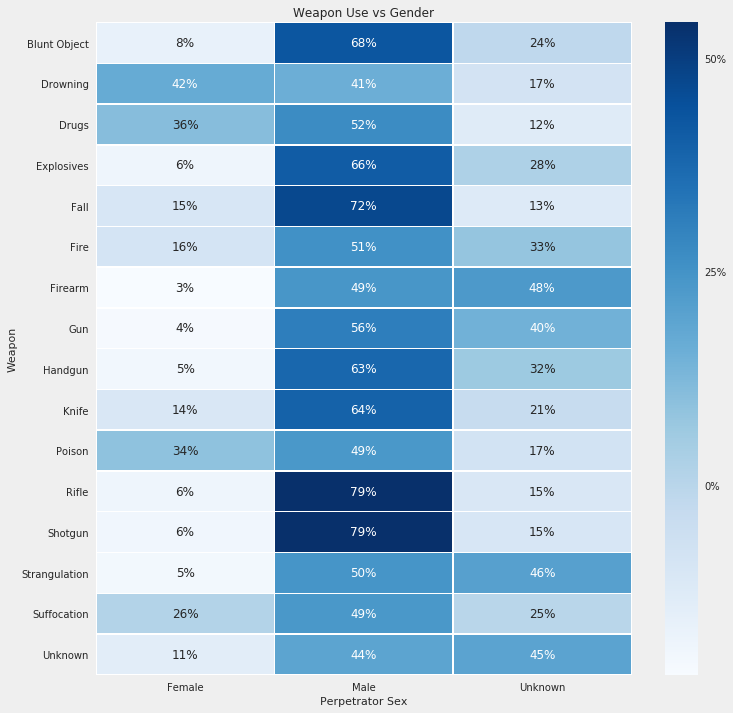

In [15]:
%%time

pyplot.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
ax = seaborn.heatmap(pandas.crosstab(homicide.Weapon, homicide['Perpetrator Sex'])
                     .apply(lambda r: r / r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Weapon Use vs Gender')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.plot()

### Show weapon use by sex with unkown filtered out.

CPU times: user 949 ms, sys: 43.9 ms, total: 993 ms
Wall time: 1.01 s


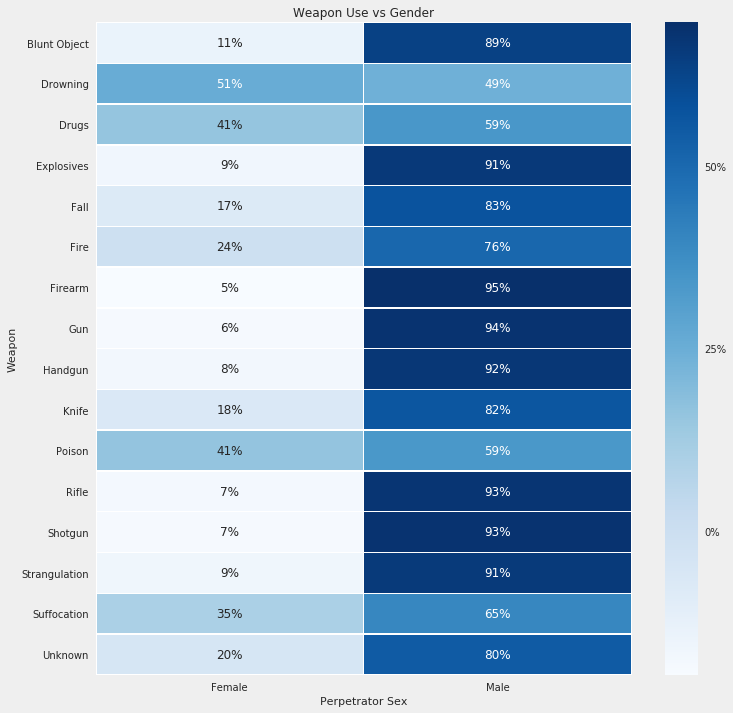

In [16]:
%%time

pyplot.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
# ax.set_ticklabels(['0%', '20%', '75%', '100%'])
unknown_filter = homicide[homicide['Perpetrator Sex'] != 'Unknown']
ax = seaborn.heatmap(pandas.crosstab(unknown_filter.Weapon, unknown_filter['Perpetrator Sex'])
                     .apply(lambda r: r / r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Weapon Use vs Gender')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.plot()

# Favoriet wapen man vs vrouw

In [17]:
%%time

Male_Filter = unknown_filter.loc[unknown_filter['Perpetrator Sex'] == "Male"]#['Weapon']
Female_Filter = unknown_filter.loc[unknown_filter['Perpetrator Sex'] == "Female"]##['Weapon']

CPU times: user 379 ms, sys: 35.8 ms, total: 415 ms
Wall time: 442 ms


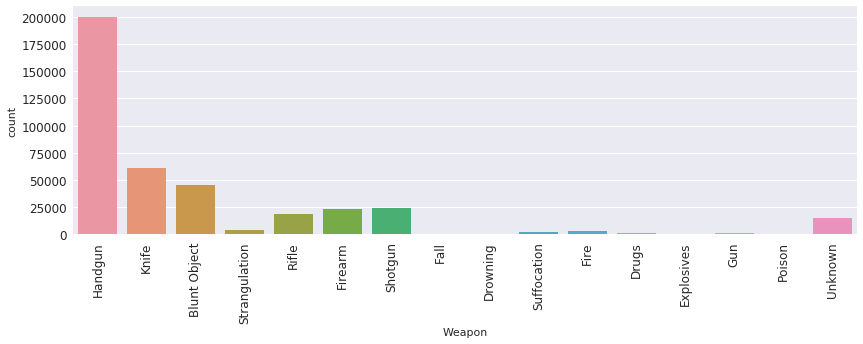

In [18]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

s = seaborn.factorplot(x='Weapon', data=Male_Filter,kind="count", aspect=3,
                      order=['Handgun','Knife','Blunt Object', 'Strangulation', 'Rifle', 'Firearm',
                       'Shotgun', 'Fall',  'Drowning', 'Suffocation', 
                       'Fire', 'Drugs', 'Explosives', 'Gun', 'Poison','Unknown' ])
s.set_xticklabels(rotation=90)

# plt.ylim(0,300000)

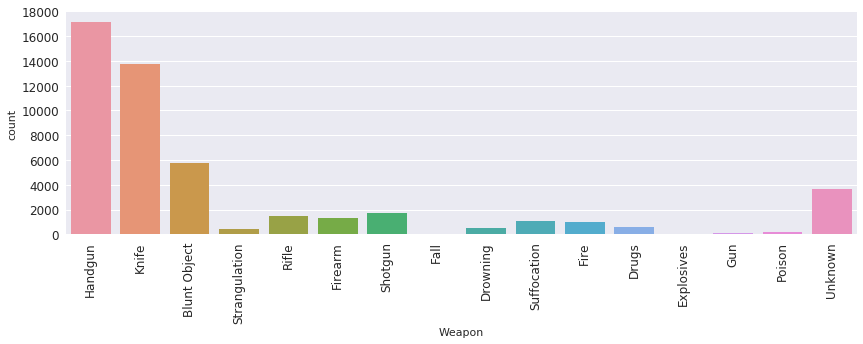

In [19]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

s = seaborn.factorplot(x='Weapon', data=Female_Filter,kind="count", aspect=3,
                       order=['Handgun','Knife','Blunt Object', 'Strangulation', 'Rifle', 'Firearm',
                       'Shotgun', 'Fall',  'Drowning', 'Suffocation',
                       'Fire', 'Drugs', 'Explosives', 'Gun', 'Poison','Unknown', ])

s.set_xticklabels(rotation=90)

### Amount of homicides per month

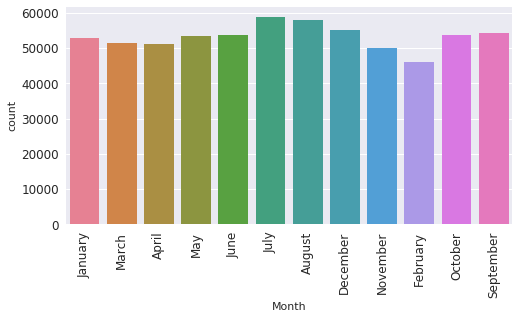

In [20]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

s = seaborn.countplot(x='Month', data=homicide, palette="husl")

for item in s.get_xticklabels():
    item.set_rotation(90)

### Show perpetrator age with unkown ages filtered out

CPU times: user 1.87 s, sys: 211 ms, total: 2.08 s
Wall time: 2.1 s


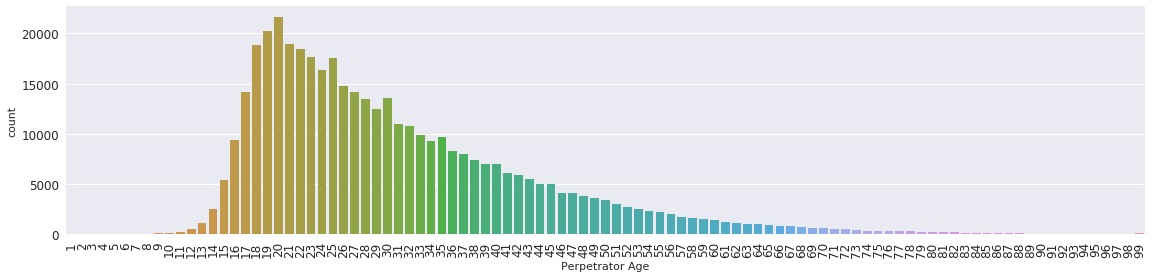

In [21]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (10, 5)

s = seaborn.factorplot(x='Perpetrator Age', data=homicide[homicide['Perpetrator Age'] != 0],
                        kind="count", aspect=4)
s.set_xticklabels(rotation=90)

plt.tight_layout

### Show perpetrator age with unkown ages filtered out grouped by perpetrator age

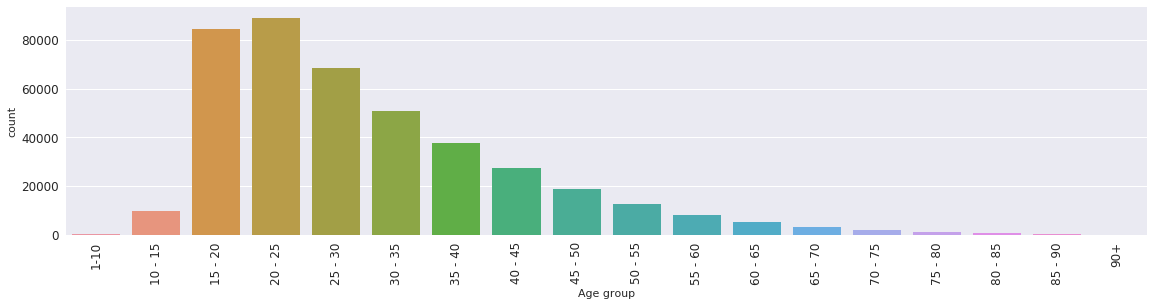

In [22]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

bins = [0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,np.inf]
labels = ['1-10','10 - 15','15 - 20','20 - 25','25 - 30','30 - 35','35 - 40','40 - 45','45 - 50','50 - 55','55 - 60','60 - 65','65 - 70','70 - 75','75 - 80','80 - 85', '85 - 90', '90+']
age_groups = pandas.cut(homicide['Perpetrator Age'], bins, labels=labels)
homicide['Age group'] = age_groups

s = seaborn.factorplot(x='Age group', data=homicide[homicide['Perpetrator Age'] != 0],
                        kind="count", aspect=4)
s.set_xticklabels(rotation=90)

### Show homcide count by race

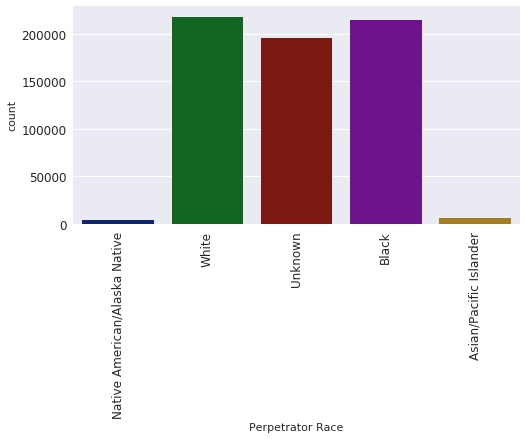

In [23]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

s = seaborn.countplot(x='Perpetrator Race', data=homicide, palette="dark")

for item in s.get_xticklabels():
    item.set_rotation(90)

### Pepetrator gender vs weapon used

CPU times: user 870 ms, sys: 3.96 ms, total: 874 ms
Wall time: 885 ms


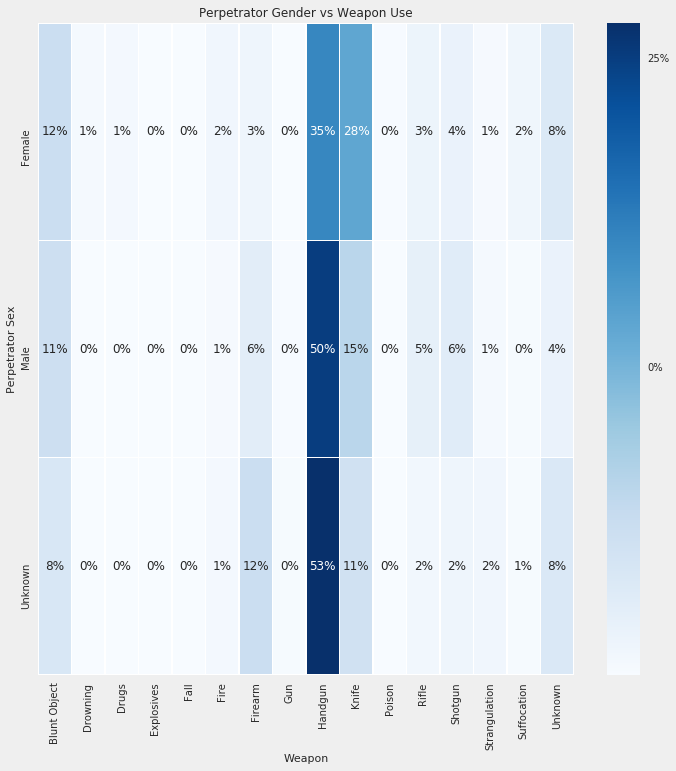

In [24]:
%%time

plt.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
# ax.set_ticklabels(['0%', '25%', '75%', '100%'])
ax = seaborn.heatmap(pandas.crosstab(homicide['Perpetrator Sex'], homicide.Weapon).apply(lambda r: r / r.sum(), axis=1),
                     annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Perpetrator Gender vs Weapon Use')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])


### Count of homcides per state

CPU times: user 2.1 s, sys: 0 ns, total: 2.1 s
Wall time: 2.11 s


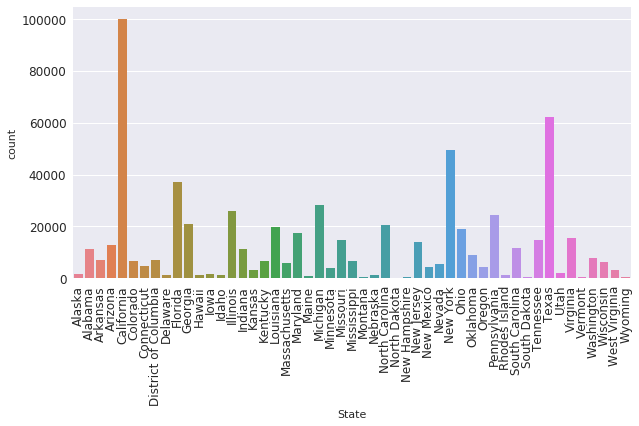

In [25]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (10, 5)

seaborn.countplot(x='State', data=homicide, palette="husl")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# Sex offenders
## Read data set

In [26]:
%%time

sexoff = pandas.read_csv("./datasets/Sex_Offenders.csv", dtype={"AGE": int})

CPU times: user 18.1 ms, sys: 0 ns, total: 18.1 ms
Wall time: 35.9 ms


## Show data

In [27]:
%time sexoff

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 22.2 µs


,LAST,FIRST,BLOCK,GENDER,RACE,BIRTH DATE,AGE,HEIGHT,WEIGHT,VICTIM MINOR
0,NIEVES,EDUARDO,033XX W CRYSTAL ST,MALE,WHITE HISPANIC,10/07/1968,48,600,200,Y
1,VALDEZ,JOSE,023XX W 23RD ST,MALE,WHITE HISPANIC,10/07/1976,40,602,235,N
2,CRAWFORD,ANDRE,11XXX S STATE ST,MALE,BLACK,10/07/1964,52,507,155,Y
3,MARTINEZ,SERGIO,054XX S ARCHER AVE,MALE,WHITE HISPANIC,10/07/1960,56,504,155,Y
4,CANCIO-HERNANDEZ,ERNESTO,015XX W GARFIELD BLVD,MALE,WHITE HISPANIC,10/08/1941,75,507,140,Y
5,URENDA,NOE,025XX W 46TH ST,MALE,WHITE HISPANIC,10/08/1973,43,506,164,Y
6,PAZ,JUAN,052XX S KILBOURN AVE,MALE,WHITE HISPANIC,10/09/1981,35,509,300,Y
7,MYLES,ROOSEVELT,002XX E 121ST ST,MALE,BLACK,10/09/1958,58,502,225,Y
8,WALTON,MARION,032XX N CICERO AVE,MALE,WHITE,10/09/1947,69,508,164,Y
9,DAVIS,DUANE,081XX S CAMPBELL AVE,MALE,BLACK,10/10/1961,55,511,180,Y


## Check if tables contain null

In [28]:
%time sexoff.isnull().any()

CPU times: user 4.25 ms, sys: 12 µs, total: 4.26 ms
Wall time: 4.28 ms


LAST            False
FIRST           False
BLOCK           False
GENDER          False
RACE            False
BIRTH DATE      False
AGE             False
HEIGHT          False
WEIGHT          False
VICTIM MINOR    False
dtype: bool

## Check data types

In [29]:
%time sexoff.dtypes

CPU times: user 500 µs, sys: 22 µs, total: 522 µs
Wall time: 533 µs


LAST            object
FIRST           object
BLOCK           object
GENDER          object
RACE            object
BIRTH DATE      object
AGE              int64
HEIGHT           int64
WEIGHT           int64
VICTIM MINOR    object
dtype: object

## Show sex offenders by race

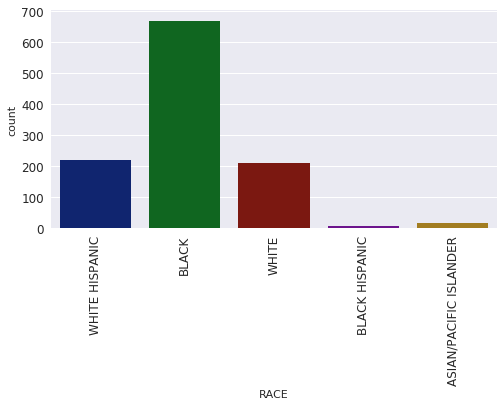

CPU times: user 453 ms, sys: 78 µs, total: 453 ms
Wall time: 490 ms


In [30]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

seaborn.countplot(x='RACE', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()


## Show amount of sex offenders by age when crime was commited

CPU times: user 485 ms, sys: 0 ns, total: 485 ms
Wall time: 501 ms


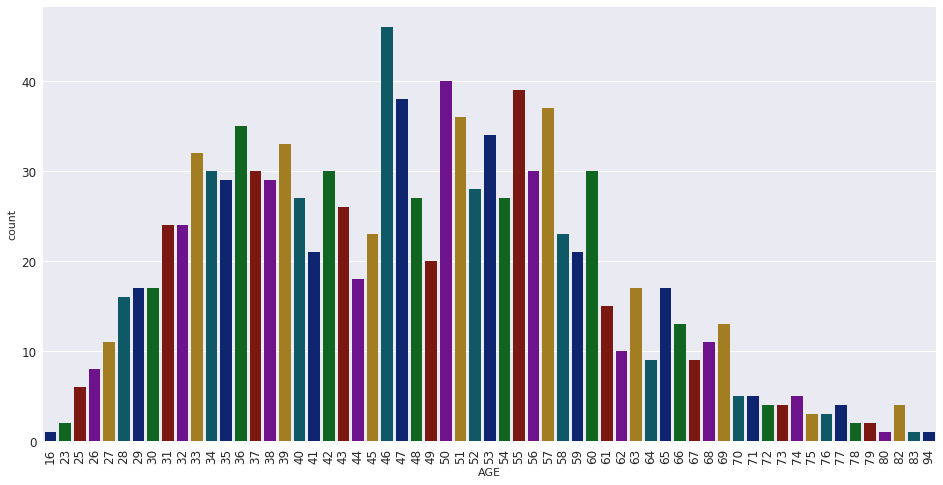

In [31]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (16, 8)

seaborn.countplot(x='AGE', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# Show amount of sex offenders grouped by age when crime was commited 

CPU times: user 252 ms, sys: 0 ns, total: 252 ms
Wall time: 268 ms


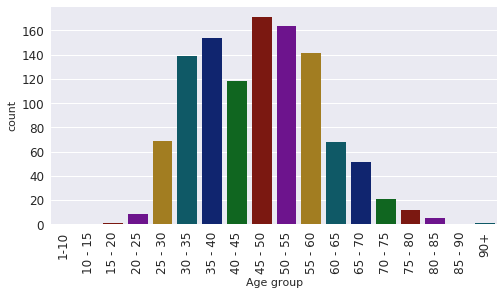

In [32]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

bins = [0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,np.inf]
labels = ['1-10','10 - 15','15 - 20','20 - 25','25 - 30','30 - 35','35 - 40','40 - 45','45 - 50','50 - 55','55 - 60','60 - 65','65 - 70','70 - 75','75 - 80','80 - 85', '85 - 90', '90+']
age_groups = pandas.cut(sexoff.AGE, bins, labels=labels)
sexoff['Age group'] = age_groups

seaborn.countplot(x='Age group', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

## Show amount of sex offenders by gender

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 183 ms


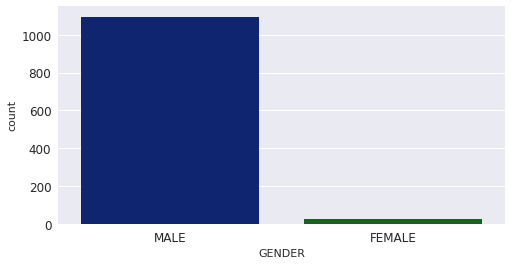

In [33]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

%time seaborn.countplot(x='GENDER', data=sexoff, palette="dark")

## Show amount of sex offenders by height

CPU times: user 277 ms, sys: 0 ns, total: 277 ms
Wall time: 288 ms


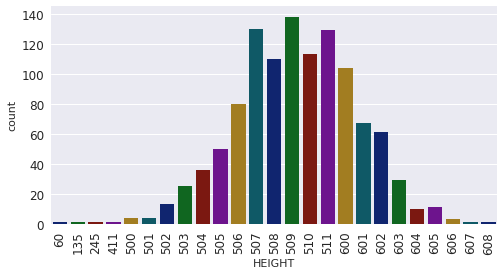

In [34]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

seaborn.countplot(x='HEIGHT', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

## Show amount of minor victims

CPU times: user 154 ms, sys: 3.73 ms, total: 157 ms
Wall time: 169 ms


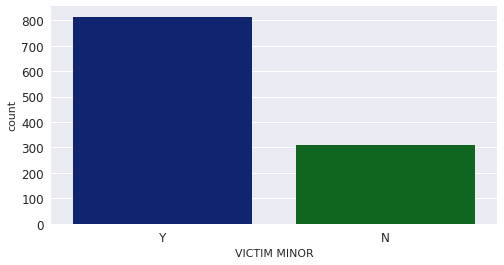

In [35]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

%time seaborn.countplot(x='VICTIM MINOR', data=sexoff, palette="dark")

## Show amount of minor and no minor victims by targeted by offender sex

CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 194 ms


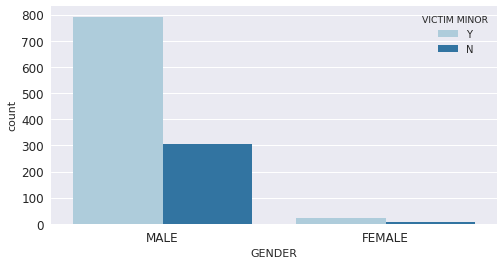

In [36]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

%time seaborn.countplot(x='GENDER', hue='VICTIM MINOR', data=sexoff, palette="Paired")

# Gun offenders in chicago
## Read data

In [37]:
%time gunoff = pandas.read_csv("./datasets/Gun_Offenders.csv")

CPU times: user 75.1 ms, sys: 3.45 ms, total: 78.6 ms
Wall time: 97.5 ms


## Print first 10 rows

In [38]:
%time gunoff

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.5 µs


,caseNumber,created_date,modified_date,lastName,firstName,middleName,Date_Of_Birth,sex,race,full_address,city,state,zip_code,district,post,neighborhood,Longitude,Latitude,Location 1
0,17-0301,08/21/2017 12:00:00 AM,08/21/2017,Gyant,Deandre,NaN,06/01/1991,Male,Black,Homeless,Homeless,MD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17-0300,08/21/2017 12:00:00 AM,08/21/2017,Brandon,Jarad,NaN,09/22/1987,Male,Black,2 S GILMOR ST Apt 2,Baltimore,MD,21223,SD,933.0,Union Square,-76.642412,39.288244,"(39.2882443122439, -76.6424122472685)"
2,17-0299,08/18/2017 12:00:00 AM,08/18/2017,Forney,Justin,NaN,12/13/1991,Male,Black,5100 CHALGROVE AV,Baltimore,MD,21215,NWD,614.0,Central Park Heights,-76.671197,39.350362,"(39.3503620513041, -76.6711973043507)"
3,17-0298,08/15/2017 12:00:00 AM,08/18/2017,White,Lanier,NaN,04/13/1992,Male,Black,8033 EastDale Rd,Dundalk,MD,21224,Out of Jurisdiction,NaN,NaN,NaN,NaN,NaN
4,17-0297,08/14/2017 12:00:00 AM,08/16/2017,Harris,Trenton,NaN,08/06/1991,Male,Black,4615 ASBURY AV,Baltimore,MD,21206,NED,443.0,Frankford,-76.560364,39.330869,"(39.3308689928877, -76.5603640282752)"
5,17-0296,08/11/2017 12:00:00 AM,08/11/2017,Davis,Ricardo,NaN,09/05/1979,Male,Black,21 Bonbon Ct,Reisterstown,MD,21236,Out of Jurisdiction,NaN,NaN,NaN,NaN,NaN
6,17-0295,08/08/2017 12:00:00 AM,08/08/2017,Morten,Harrison,NaN,11/17/1992,Male,Black,6838 STURBRIDGE DR Apt A,Baltimore,MD,21234,NED,423.0,Hamilton Hills,-76.563046,39.368921,"(39.3689207814868, -76.5630464640503)"
7,17-0294,08/08/2017 12:00:00 AM,08/08/2017,Reeder,Renard,NaN,03/03/1995,Male,Black,5019 ARBUTUS AV,Baltimore,MD,21215,NWD,613.0,Langston Hughes,-76.680500,39.342546,"(39.3425459213419, -76.6805001216217)"
8,17-0293,08/02/2017 12:00:00 AM,08/02/2017,Morris,Leonard,NaN,10/02/1986,Male,Black,1535 W FAIRMOUNT AV,Baltimore,MD,21223,WD,711.0,Franklin Square,-76.641556,39.288952,"(39.2889518905777, -76.6415560927958)"
9,17-0292,07/12/2017 12:00:00 AM,07/19/2017,Radcliffe,Theodore,NaN,11/09/1985,Male,Black,7 WHEELER AV,Baltimore,MD,21223,WD,714.0,Penrose/Fayette Street Outreach,-76.654333,39.288331,"(39.2883312342885, -76.6543325967314)"


## Check if our columns contains null data

In [39]:
%time gunoff.isnull().any()

CPU times: user 15.5 ms, sys: 3.62 ms, total: 19.1 ms
Wall time: 37.8 ms


caseNumber       False
created_date     False
modified_date    False
lastName         False
firstName        False
middleName        True
Date_Of_Birth    False
sex              False
race             False
full_address      True
city              True
state             True
zip_code          True
district          True
post              True
neighborhood      True
Longitude         True
Latitude          True
Location 1        True
dtype: bool

## Check which types our columns contains

In [40]:
%time gunoff.dtypes

CPU times: user 609 µs, sys: 27 µs, total: 636 µs
Wall time: 649 µs


caseNumber        object
created_date      object
modified_date     object
lastName          object
firstName         object
middleName        object
Date_Of_Birth     object
sex               object
race              object
full_address      object
city              object
state             object
zip_code          object
district          object
post             float64
neighborhood      object
Longitude        float64
Latitude         float64
Location 1        object
dtype: object

## Show amount of gun offenders by race

CPU times: user 312 ms, sys: 7.66 ms, total: 320 ms
Wall time: 334 ms


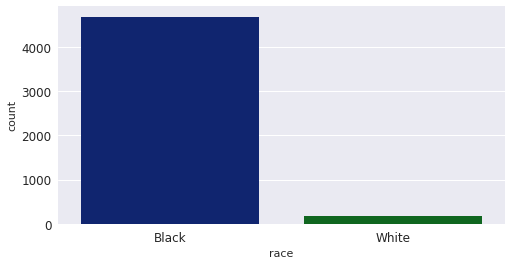

In [41]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

seaborn.countplot(x='race', data=gunoff, palette="dark")

## Show amount of gun offenders by Sex

CPU times: user 160 ms, sys: 8 ms, total: 168 ms
Wall time: 189 ms


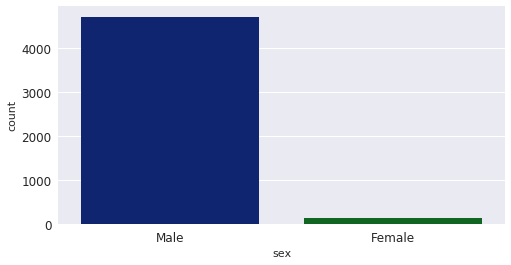

In [42]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

seaborn.countplot(x='sex', data=gunoff, palette="dark")

## Show ammount of gun offenders per state

CPU times: user 295 ms, sys: 0 ns, total: 295 ms
Wall time: 309 ms


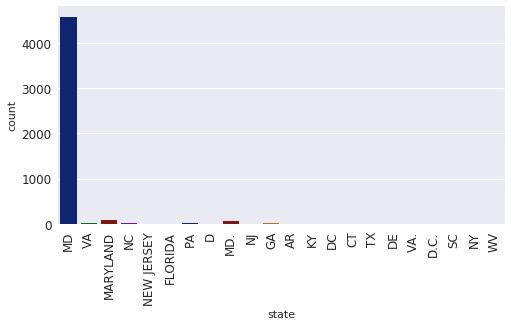

In [43]:
%%time

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["figure.figsize"] = (8, 4)

seaborn.countplot(x='state', data=gunoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

# Map US With Homicide rates per State



In [44]:
%%time

homicides_per_state = pandas.read_csv("./datasets/homicides_per_state.csv")

CPU times: user 5.92 ms, sys: 3.73 ms, total: 9.65 ms
Wall time: 22.4 ms


In [45]:
us_states = os.path.join('datasets', 'us-states.json')



map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=us_states, 
               data=homicides_per_state,
               columns=['STATE', 'RATE'],
               key_on='feature.id',
               fill_color='YlOrRd',
              legend_name='Homicide Rate (%)')            
map

## Map US with Firearm mortality rates per state:

In [46]:
%%time

firearms = pandas.read_csv("./datasets/firearms.csv")

CPU times: user 2.05 ms, sys: 3.79 ms, total: 5.84 ms
Wall time: 17.9 ms


In [47]:
map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=us_states, 
               data=firearms,
               columns=['STATE', 'RATE'],
               key_on='feature.id',
               fill_color='YlOrRd',
              legend_name='Gun Mortality Rate (%)')

map